<a href="https://colab.research.google.com/github/Pashtetickus/Nornikel_prac/blob/main/flight_delay_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание:


Делал дольше, чем предполагал (думал к среде уже накидаю таблицу) из-за маленькоо скора катбуста - перебирал фичи пока скор не стал адекватным.

In [ ]:
!pip install catboost
!pip install bayesian-optimization

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_curve, roc_auc_score
from catboost import CatBoostClassifier, Pool, cv
from bayes_opt import BayesianOptimization

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
set_matplotlib_formats('svg')


def plot_confusion_matrix(targets,predictions, classes,
                          normalize=False, title='Confusion matrix',
                          figsize=(4, 4), cmap=plt.cm.Reds):

    conf_matrix = confusion_matrix(y_true=targets, y_pred=predictions)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title.lower()

    plt.figure(figsize=figsize)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):

        if normalize:
            value = '{} %'.format(format(conf_matrix[i, j] * 100, '.2f'))
        else:
            value = format(conf_matrix[i, j], fmt)

        plt.text(j,i,value,horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

In [4]:
path_to_dataset = '/content/drive/MyDrive/Универ/5 курс/Прак/1_task/flight_delays.csv'
data = pd.read_csv(path_to_dataset)
data.head(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,N
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,N
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,N
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,N


In [5]:
data['dep_delayed_15min'] = (data['dep_delayed_15min'] == 'Y').astype(int)
target = data['dep_delayed_15min']
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1


In [6]:
data.isna().any() # в начале надо было проверить

Month                False
DayofMonth           False
DayOfWeek            False
DepTime              False
UniqueCarrier        False
Origin               False
Dest                 False
Distance             False
dep_delayed_15min    False
dtype: bool

В попытках понять что улучшает бустинг натыкался на вопрос что делать со временем. Кажется оно просто не разделено двоеточием на часы и минуты, поэтому попробую сделать новые признаки и подумать куда девать 24 и 25.

In [7]:
data['hour'] = data['DepTime'] // 100
data['minute'] = data['DepTime'] % 100
print(sorted(data['hour'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [8]:
data.loc[data['hour'] == 24, 'hour'] = 0 # 12 ночи
data.loc[data['hour'] == 25, 'hour'] = 1 # 1 ночи

In [9]:
print(sorted(data['hour'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [10]:
data['Month'] = data['Month'].apply(lambda x: int(x[2:]))
data['DayofMonth'] = data['DayofMonth'].apply(lambda x: int(x[2:]))
data['DayOfWeek'] = data['DayOfWeek'].apply(lambda x: int(x[2:]))

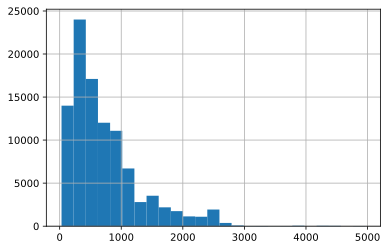

In [11]:
data['Distance'].hist(bins=25); # похоже на логнормальное

Видел попытку присвоить веса каждому перевозчику (аэропорту назначения/вылета) в зависимости от кол-ва задержек.  
Большее значение метки соответствует большему весу (больше задержек).  
По идее интерпретировать так можно, т.к. у меток может быть отношение порядка раз они числа 

In [12]:
def groupby_encode(category: str, cat_unique_count: int):
    _df = (data[[category, 'dep_delayed_15min']]
                .groupby(category)
                .sum()
                .sort_values(by='dep_delayed_15min', ascending=False)
                )

    _df[f'{category}_cat'] = pd.qcut(_df['dep_delayed_15min'],
                                     cat_unique_count,
                                     labels=False,
                                     duplicates='drop')
    return _df

In [13]:
UniqueCarrier_count = data['UniqueCarrier'].nunique()
carrier_df = groupby_encode('UniqueCarrier', UniqueCarrier_count)
carrier_df = carrier_df.loc[data['UniqueCarrier']].reset_index()

data['UniqueCarrier_cat'] = carrier_df['UniqueCarrier_cat']

carrier_df

,UniqueCarrier,dep_delayed_15min,UniqueCarrier_cat
0,AA,1770,20
1,US,1085,15
2,XE,1026,12
3,OO,1277,16
4,WN,3219,21
...,...,...,...
99995,OO,1277,16
99996,CO,788,10
99997,NW,1075,13
99998,MQ,1448,19


In [15]:
Dest_count = 25
Dest_df = groupby_encode('Dest', Dest_count)
Dest_df = Dest_df.loc[data['Dest']].reset_index()

data['Dest_cat'] = Dest_df['Dest_cat']

In [16]:
Origin_count = 25
Origin_df = groupby_encode('Origin', Origin_count)
Origin_df = Origin_df.loc[data['Origin']].reset_index()

data['Origin_cat'] = Origin_df['Origin_cat']

In [17]:
data['sin_hour'] = np.sin(2 * np.pi * data['hour'] / 24)
data['cos_hour'] = np.cos(2 * np.pi * data['hour'] / 24)

data['Distance'] = np.log(data['Distance'])

data['on_weekend'] = (data['DayOfWeek'] > 5).astype(int)

data['carrier_origin'] = data['UniqueCarrier'] + '_' + data['Origin']
data['carrier_dest'] = data['UniqueCarrier'] + '_' + data['Dest']
data['Route'] = data['Origin'] + "_" + data['Dest']

data.drop(['DepTime', 'Origin', 'Dest', 'UniqueCarrier'], axis=1, inplace=True)
data.head()

,Month,DayofMonth,DayOfWeek,Distance,dep_delayed_15min,hour,minute,UniqueCarrier_cat,Dest_cat,Origin_cat,sin_hour,cos_hour,on_weekend,carrier_origin,carrier_dest,Route
0,8,21,7,6.595781,0,19,34,20,22,20,-0.965926,2.588190e-01,1,AA_ATL,AA_DFW,ATL_DFW
1,4,20,3,6.726233,0,15,48,15,21,17,-0.707107,-7.071068e-01,0,US_PIT,US_MCO,PIT_MCO
2,9,2,5,6.030685,0,14,22,12,20,18,-0.500000,-8.660254e-01,0,XE_RDU,XE_CLE,RDU_CLE
3,11,25,6,6.770789,0,10,15,16,18,20,0.500000,-8.660254e-01,1,OO_DEN,OO_MEM,DEN_MEM
4,10,7,6,6.047372,1,18,28,21,18,19,-1.000000,-1.836970e-16,1,WN_MDW,WN_OMA,MDW_OMA


In [18]:
LE = LabelEncoder()
data['Route'] = LE.fit_transform(data['Route'])
data['carrier_origin'] = LE.fit_transform(data['carrier_origin'])
data['carrier_dest'] = LE.fit_transform(data['carrier_dest'])

data = pd.get_dummies(data, columns=['Month', 'DayOfWeek', 'UniqueCarrier_cat'])
data.head()

,DayofMonth,Distance,dep_delayed_15min,hour,minute,Dest_cat,Origin_cat,sin_hour,cos_hour,on_weekend,carrier_origin,carrier_dest,Route,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,UniqueCarrier_cat_0,UniqueCarrier_cat_1,UniqueCarrier_cat_2,UniqueCarrier_cat_3,UniqueCarrier_cat_5,UniqueCarrier_cat_6,UniqueCarrier_cat_7,UniqueCarrier_cat_8,UniqueCarrier_cat_9,UniqueCarrier_cat_10,UniqueCarrier_cat_11,UniqueCarrier_cat_12,UniqueCarrier_cat_13,UniqueCarrier_cat_14,UniqueCarrier_cat_15,UniqueCarrier_cat_16,UniqueCarrier_cat_17,UniqueCarrier_cat_18,UniqueCarrier_cat_19,UniqueCarrier_cat_20,UniqueCarrier_cat_21
0,21,6.595781,0,19,34,22,20,-0.965926,2.588190e-01,1,2,18,152,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,20,6.726233,0,15,48,21,17,-0.707107,-7.071068e-01,0,1393,1392,3527,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,6.030685,0,14,22,20,18,-0.500000,-8.660254e-01,0,1579,1524,3619,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,25,6.770789,0,10,15,18,20,0.500000,-8.660254e-01,1,1125,1172,1181,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,7,6.047372,1,18,28,18,19,-1.000000,-1.836970e-16,1,1453,1475,2681,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [19]:
data.drop(['dep_delayed_15min'], axis=1, inplace=True)

полиномы добавили точности

In [20]:
poly = PolynomialFeatures(2)
data_poly = poly.fit_transform(data)
data_poly

array([[ 1.        , 21.        ,  6.59578051, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        , 20.        ,  6.7262334 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  2.        ,  6.03068526, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.        , 24.        ,  6.98100574, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , 27.        ,  4.94164242, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , 17.        ,  6.40522846, ...,  0.        ,
         0.        ,  1.        ]])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(data_poly, target, test_size=0.1, random_state=SEED)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

y_train = y_train.to_numpy(np.float32)
y_test = y_test.to_numpy(np.float32)

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

In [22]:
class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out) # BCELoss
        return out

In [23]:
input_dim = x_train.shape[1]

criterion = nn.BCELoss()
lr = 1e-02

model = LogisticRegressionTorch(input_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [24]:
iter = 0
num_epochs = 1200
history_train_loss = []
history_val_loss = []

for epoch in range(num_epochs):
    y_hat = model(x_train)

    loss = criterion(y_hat, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    iter += 1

    if (epoch + 1) % 50 == 0:
        y_val_hat = model(x_test)
        val_loss = criterion(y_val_hat, y_test)
        history_train_loss.append(loss.item())

        history_val_loss.append(val_loss.item())
        print(f'epoch {epoch + 1}, loss {loss.item():.4f}, val_loss {val_loss.item():.4f}')

epoch 50, loss 0.6435, val_loss 0.6422
epoch 100, loss 0.6028, val_loss 0.6023
epoch 150, loss 0.5717, val_loss 0.5717
epoch 200, loss 0.5472, val_loss 0.5477
epoch 250, loss 0.5277, val_loss 0.5286
epoch 300, loss 0.5121, val_loss 0.5134
epoch 350, loss 0.4995, val_loss 0.5011
epoch 400, loss 0.4892, val_loss 0.4912
epoch 450, loss 0.4808, val_loss 0.4830
epoch 500, loss 0.4738, val_loss 0.4763
epoch 550, loss 0.4680, val_loss 0.4707
epoch 600, loss 0.4632, val_loss 0.4661
epoch 650, loss 0.4591, val_loss 0.4622
epoch 700, loss 0.4556, val_loss 0.4589
epoch 750, loss 0.4527, val_loss 0.4561
epoch 800, loss 0.4502, val_loss 0.4537
epoch 850, loss 0.4480, val_loss 0.4517
epoch 900, loss 0.4461, val_loss 0.4499
epoch 950, loss 0.4445, val_loss 0.4484
epoch 1000, loss 0.4431, val_loss 0.4471
epoch 1050, loss 0.4418, val_loss 0.4459
epoch 1100, loss 0.4407, val_loss 0.4449
epoch 1150, loss 0.4398, val_loss 0.4441
epoch 1200, loss 0.4389, val_loss 0.4433


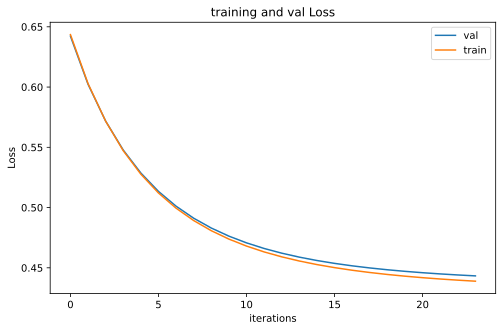

In [25]:
plt.figure(figsize=(8, 5))
plt.title("training and val Loss")
plt.plot(history_val_loss, label="val")
plt.plot(history_train_loss, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [26]:
with torch.no_grad():
    y_hat = model(x_test)
    predicted_class = (y_hat > 0.3).float()
    accuracy = predicted_class.eq(y_test).sum() / float(len(y_test))

    print(f'accuracy = {accuracy:.4f}')

accuracy = 0.7427


Общее число совпадений 0.7427
Полнота охвата класса 1: 0.4607792207792208
Точность: 0.3662262592898431
ROC_AUC: 0.7225605725543806


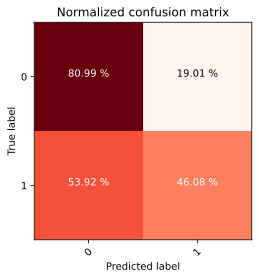

In [27]:
print('Общее число совпадений', accuracy_score(y_test, predicted_class))
print('Полнота охвата класса 1:', recall_score(y_test, predicted_class))
print('Точность:', precision_score(y_test, predicted_class))
print('ROC_AUC:', roc_auc_score(y_test, y_hat))
plot_confusion_matrix(y_test, predicted_class, [0,1], normalize=True)

## FE with trees


In [28]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=SEED)

In [30]:
model = DecisionTreeClassifier(max_depth=40, min_samples_split=2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)[:, 1]

Общее число совпадений 0.7342
Полнота охвата класса 1: 0.3220779220779221
Точность: 0.31424227065382665
ROC_AUC: 0.576460520284669


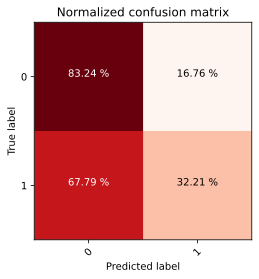

In [31]:
print('Общее число совпадений', accuracy_score(y_test, y_pred))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred))
print('Точность:', precision_score(y_test, y_pred))
print('ROC_AUC:', roc_auc_score(y_test, y_proba))
plot_confusion_matrix(y_test, y_pred, [0, 1], normalize=True)

## SVM

Надо крутить параметры или тут что-то не так

In [32]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=SEED)

In [33]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [34]:
model = SVC(gamma='auto', max_iter=500)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_proba = np.array(model.decision_function(x_test))

Общее число совпадений 0.7636
Полнота охвата класса 1: 0.11636363636363636
Точность: 0.2525366403607666
ROC_AUC: 0.5446404889228418


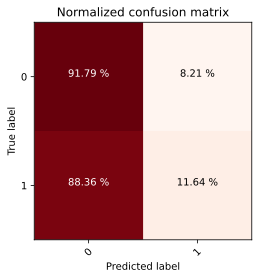

In [35]:
print('Общее число совпадений', accuracy_score(y_test, y_pred))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred))
print('Точность:', precision_score(y_test, y_pred))
print('ROC_AUC:', roc_auc_score(y_test, y_proba))
plot_confusion_matrix(y_test, y_pred, [0, 1], normalize=True)

## catboost

### подготовка данных ctrl-c

Лучшие показатели:


*   Общее число совпадений 0.8381
*   Полнота охвата класса 1: 0.3724
*   Точность: 0.6356
*   ROC_AUC: 0.8348






In [38]:
data = pd.read_csv(path_to_dataset)

data['Month'] = data['Month'].apply(lambda x: int(x[2:]))
data['DayofMonth'] = data['DayofMonth'].apply(lambda x: int(x[2:]))
data['DayOfWeek'] = data['DayOfWeek'].apply(lambda x: int(x[2:]))

data['on_weekend'] = (data['DayOfWeek'] > 5).astype(int)

data['hour'] = data['DepTime'] // 100
data['minute'] = data['DepTime'] % 100
data.loc[data['hour'] == 24, 'hour'] = 0
data.loc[data['hour'] == 25, 'hour'] = 1

data['sin_hour'] = np.sin(2 * np.pi * data['hour'] / 24)
data['cos_hour'] = np.cos(2 * np.pi * data['hour'] / 24)

data['Route'] = data['Origin'] + '_' + data['Dest']

data.drop(['dep_delayed_15min'], axis=1, inplace=True)
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,on_weekend,hour,minute,sin_hour,cos_hour,Route
0,8,21,7,1934,AA,ATL,DFW,732,1,19,34,-0.965926,2.588190e-01,ATL_DFW
1,4,20,3,1548,US,PIT,MCO,834,0,15,48,-0.707107,-7.071068e-01,PIT_MCO
2,9,2,5,1422,XE,RDU,CLE,416,0,14,22,-0.500000,-8.660254e-01,RDU_CLE
3,11,25,6,1015,OO,DEN,MEM,872,1,10,15,0.500000,-8.660254e-01,DEN_MEM
4,10,7,6,1828,WN,MDW,OMA,423,1,18,28,-1.000000,-1.836970e-16,MDW_OMA


In [39]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=SEED)

### конец подготовки

Попытка байесовской оптимизации вместо grid search и сравнение с дефолтными параметрами.
Возможно, стоит увеличить init_points и сравнить с гридсерчем.

In [42]:
cat_features = [
                'Month',
                'DayofMonth',
                'DayOfWeek',
                'hour',
                'on_weekend',
                'UniqueCarrier',
                'Origin',
                'Dest',
                'Route',
]


def cat_eval(lr, max_depth, bagging_temperature, l2_leaf_reg):
    params = {
                'bagging_temperature': bagging_temperature,
                'learning_rate': lr,
                'loss_function': 'Logloss',
                'l2_leaf_reg': l2_leaf_reg,
                'iterations': 500,
                'eval_metric': "AUC",
                'verbose': False
    }
              
    cv_dataset = Pool(data=x_train,
                      label=y_train,
                      cat_features=cat_features)
    
    scores = cv(cv_dataset,
                params,
                fold_count=3)
    
    return scores['test-AUC-mean'].max()

In [43]:
cat_opt = BayesianOptimization(cat_eval, {
                                          "lr": (0.001, 0.2),
                                          'max_depth': (5, 12),
                                          'bagging_temperature': (0.1, 0.9),
                                          'l2_leaf_reg': (2, 5)
                                          }
                               )

cat_opt.maximize(n_iter=5, init_points=2)

|   iter    |  target   | baggin... | l2_lea... |    lr     | max_depth |
-------------------------------------------------------------------------


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Training on fold [0/3]

bestTest = 0.8077688552
bestIteration = 496

Training on fold [1/3]

bestTest = 0.8014264938
bestIteration = 498

Training on fold [2/3]

bestTest = 0.7992598798
bestIteration = 499

|  1        |  0.8028   |  0.2039   |  2.651    |  0.1141   |  5.577    |
Training on fold [0/3]

bestTest = 0.7822445226
bestIteration = 499

Training on fold [1/3]

bestTest = 0.7781976114
bestIteration = 499

Training on fold [2/3]

bestTest = 0.7757530311
bestIteration = 499

|  2        |  0.7787   |  0.2289   |  4.126    |  0.02829  |  6.793    |
Training on fold [0/3]

bestTest = 0.809243014
bestIteration = 450

Training on fold [1/3]

bestTest = 0.8028036172
bestIteration = 498

Training on fold [2/3]

bestTest = 0.7972493089
bestIteration = 339

|  3        |  0.8022   |  0.9      |  2.0      |  0.2      |  12.0     |
Training on fold [0/3]

bestTest = 0.7058187919
bestIteration = 487

Training on fold [1/3]

bestTest = 0.7029966636
bestIteration = 497

Training on fold [2/

In [44]:
cat_opt.max

{'params': {'bagging_temperature': 0.1,
  'l2_leaf_reg': 5.0,
  'lr': 0.2,
  'max_depth': 12.0},
 'target': 0.8031451092025308}

In [45]:
params = {
          'iterations': 500,
          'eval_metric': "AUC",
          'loss_function': 'Logloss',
          'bagging_temperature': 0.1,
          'l2_leaf_reg': 5,
          'learning_rate': 0.2,
          'max_depth': 12,
          'random_state': SEED,
          'verbose': True

}

cat_model = CatBoostClassifier(**params)

cat_model.fit(x_train,
              y_train, 
              cat_features=cat_features,
              eval_set=(x_test, y_test),
              use_best_model=True
)
y_pred = cat_model.predict(x_test)
y_proba = cat_model.predict_proba(x_test)[:, 1]

Общее число совпадений 0.8296
Полнота охвата класса 1: 0.3641558441558442
Точность: 0.5935647756138865
ROC_AUC: 0.8175585702223472


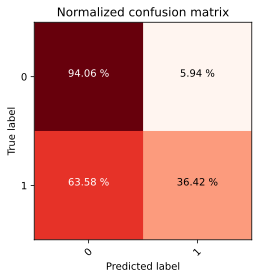

In [46]:
print('Общее число совпадений', accuracy_score(y_test, y_pred))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred))
print('Точность:', precision_score(y_test, y_pred))
print('ROC_AUC:', roc_auc_score(y_test, y_proba))
plot_confusion_matrix(y_test, y_pred, [0, 1], normalize=True)

дефолтные параметры

In [ ]:
cat_model = CatBoostClassifier(500, eval_metric='AUC', random_state=SEED)

cat_model.fit(x_train,
              y_train, 
              cat_features=cat_features,
              eval_set=(x_test, y_test),
              use_best_model=True
)
y_pred = cat_model.predict(x_test)
y_proba = cat_model.predict_proba(x_test)[:, 1]

Общее число совпадений 0.835
Полнота охвата класса 1: 0.37194805194805197
Точность: 0.6188418323249784
ROC_AUC: 0.8326139841582566


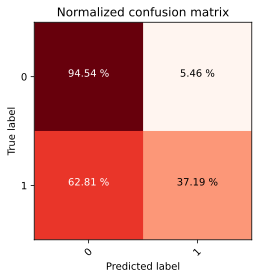

In [52]:
print('Общее число совпадений', accuracy_score(y_test, y_pred))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred))
print('Точность:', precision_score(y_test, y_pred))
print('ROC_AUC:', roc_auc_score(y_test, y_proba))
plot_confusion_matrix(y_test, y_pred, [0, 1], normalize=True)

model.get_all_params()

невнятное объединение параметров дефолтной модели с полученными из байесовской опптимизации (качество чуть лучше дефолтного)

In [ ]:
params = {
          'iterations': 500,
          'eval_metric': "AUC",
          'loss_function': 'Logloss',
          'bagging_temperature': 0.1,
          'l2_leaf_reg': 3,
          'learning_rate': 0.130182,
          'max_depth': 6,
          'random_state': SEED,
          'verbose': True

}

cat_model = CatBoostClassifier(**params)

cat_model.fit(x_train,
              y_train, 
              cat_features=cat_features,
              eval_set=(x_test, y_test),
              use_best_model=True
)
y_pred = cat_model.predict(x_test)
y_proba = cat_model.predict_proba(x_test)[:, 1]

Общее число совпадений 0.8381
Полнота охвата класса 1: 0.37246753246753245
Точность: 0.6356382978723404
ROC_AUC: 0.8348644445337943


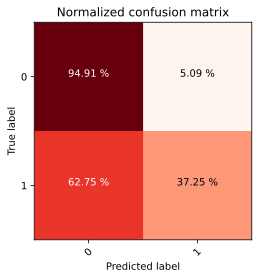

In [56]:
print('Общее число совпадений', accuracy_score(y_test, y_pred))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred))
print('Точность:', precision_score(y_test, y_pred))
print('ROC_AUC:', roc_auc_score(y_test, y_proba))
plot_confusion_matrix(y_test, y_pred, [0, 1], normalize=True)